In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np

import sys
import os

sys.path.append(os.environ['REPO_DIR'] + '/utilities')
from utilities2015 import *
from metadata import *
from data_manager import *

from learning_utilities import *

import matplotlib.pyplot as plt
%matplotlib inline

import mxnet as mx

from joblib import Parallel, delayed
import time

Setting environment for Precision WorkStation


In [2]:
stack = 'MD589'

In [3]:
label_gridIndices = locate_annotated_patches(stack=stack, 
                                             annotation_rootdir=annotation_midbrainIncluded_v2_rootdir, 
                                             cerebellum_removed=True,
                                            force=True)

Loaded annotation /home/yuncong/CSHL_labelings_v2/MD589/MD589_sagittal_downsample1_yuncong_08182016062306.pkl.
Section 93 is not in labelings.
Section 94 is not in labelings.
Section 95 is not in labelings.
Section 96 is not in labelings.
Section 97 is not in labelings.
Section 98 is not in labelings.
Section 99 is not in labelings.
Section 100 is not in labelings.
Section 101 is not in labelings.
Section 102 is not in labelings.
Section 103 is not in labelings.
Section 104 is not in labelings.
Section 105 is not in labelings.
Section 106 is not in labelings.
Section 107 is not in labelings.
Section 108 is not in labelings.
Section 109 is not in labelings.
Label DC on Section 110 is not recognized.
Label DC on Section 111 is not recognized.
Label VCA on Section 111 is not recognized.
Label VCP on Section 111 is not recognized.
Section 112 is not in labelings.
Label VCP on Section 113 is not recognized.
Label DC on Section 113 is not recognized.
Label VCA on Section 113 is not recognize

587 patches in SNR_L
67 patches in 5TT_L
25 patches in X_L
122 patches in 5N_L
1542 patches in IC_L
32 patches in SNC_L
129 patches in sp5
49 patches in 7n_L
83 patches in VLL_L
1586 patches in SC_L
1200 patches in SNR_L_surround
528 patches in 5TT_L_surround
490 patches in X_L_surround
566 patches in 5N_L_surround
656 patches in IC_L_surround
467 patches in SNC_L_surround
2068 patches in sp5_surround
512 patches in 7n_L_surround
535 patches in VLL_L_surround
1261 patches in SC_L_surround
25369 patches in bg
1077 patches in Sp5C_L
641 patches in SNR_L
20 patches in X_L
70 patches in 5N_L
192 patches in sp5
116 patches in VLL_L
48 patches in 7n_L
321 patches in MVeMC_L
1742 patches in Sp5I_R
52 patches in 5TT_R
120 patches in SuVe_L
135 patches in LVe_L
1050 patches in Sp5C_L_surround
1282 patches in SNR_L_surround
384 patches in X_L_surround
506 patches in 5N_L_surround
1655 patches in sp5_surround
618 patches in VLL_L_surround
524 patches in 7n_L_surround
689 patches in MVeMC_L_surrou

In [121]:
num_samples_per_landmark = 100
num_samples_per_polygon = None

# num_samples_per_polygon = 10
# num_samples_per_polygon = 9999

In [122]:
all_names_sided = list(label_gridIndices.index)

In [123]:
structures_to_extract = ['5N', '7N', '7n', 'Pn', 'RtTg', 'VLL', 'SNR', 'SNC', 'SC', 'IC', 'DC', '8n', 'LSO', 'Amb', 
                        'LRt', 'LC', 'Tz', 'R', '6N', '12N', '10N', '3N', '4N', 'IO', 'Sol', 'Gr', 'Cu', 'AP']

In [124]:
structures_to_extract = ['5N', '7N', '7n', 'Pn', 'RtTg', 'VLL', 'Amb', '6N', 'AP', 'LC', 'LRt', 'R', 'Tz', '12N']

In [125]:
structures_to_extract_sided = set(chain(*[[name_u] if name_u in singular_structures else [convert_to_left_name(name_u), convert_to_right_name(name_u)] 
                                        for name_u in structures_to_extract]))

In [126]:
def sample_locations(grid_indices_lookup, structures):

    location_list = defaultdict(list)

    for name in structures:

        if name not in grid_indices_lookup.index:
            continue

        for sec, grid_indices in grid_indices_lookup.loc[name].dropna().to_dict().iteritems():

            n = len(grid_indices)

            if n == 0:
                sys.stderr.write('Cell is empty.\n')
                continue


            if num_samples_per_polygon is None:
                location_list[name] += [(stack, sec, i) for i in grid_indices]

            else:
                random_sampled_indices = grid_indices[np.random.choice(range(n), min(n, num_samples_per_polygon), replace=False)]
                location_list[name] += [(stack, sec, i) for i in random_sampled_indices]

    if num_samples_per_polygon is None:
        return location_list

    else:

        sampled_location_list = {}
        for name_s, addresses in location_list.iteritems():
            n = len(addresses)
            random_sampled_indices = np.random.choice(range(n), min(n, num_samples_per_landmark), replace=False)
            sampled_location_list[name_s] = [addresses[i] for i in random_sampled_indices]
        return sampled_location_list


In [127]:
location_list = sample_locations(label_gridIndices, structures_to_extract_sided)

In [128]:
def apply_function_to_dict(func, d):
    """
    Func applies to the list consisting of all elements of d, and return a list.
    """
    result = func(list(chain(*d.values())))
    csum = np.cumsum(map(len, d.values()))
    new_d = {k: result[(0 if i == 0 else csum[i-1]):csum[i]] for i, k in enumerate(d.keys())}  
    return new_d

In [ ]:
from functools import partial

patches = apply_function_to_dict(partial(extract_patches_given_locations_multiple_sections, location_or_grid_index='index'), 
                                 location_list)

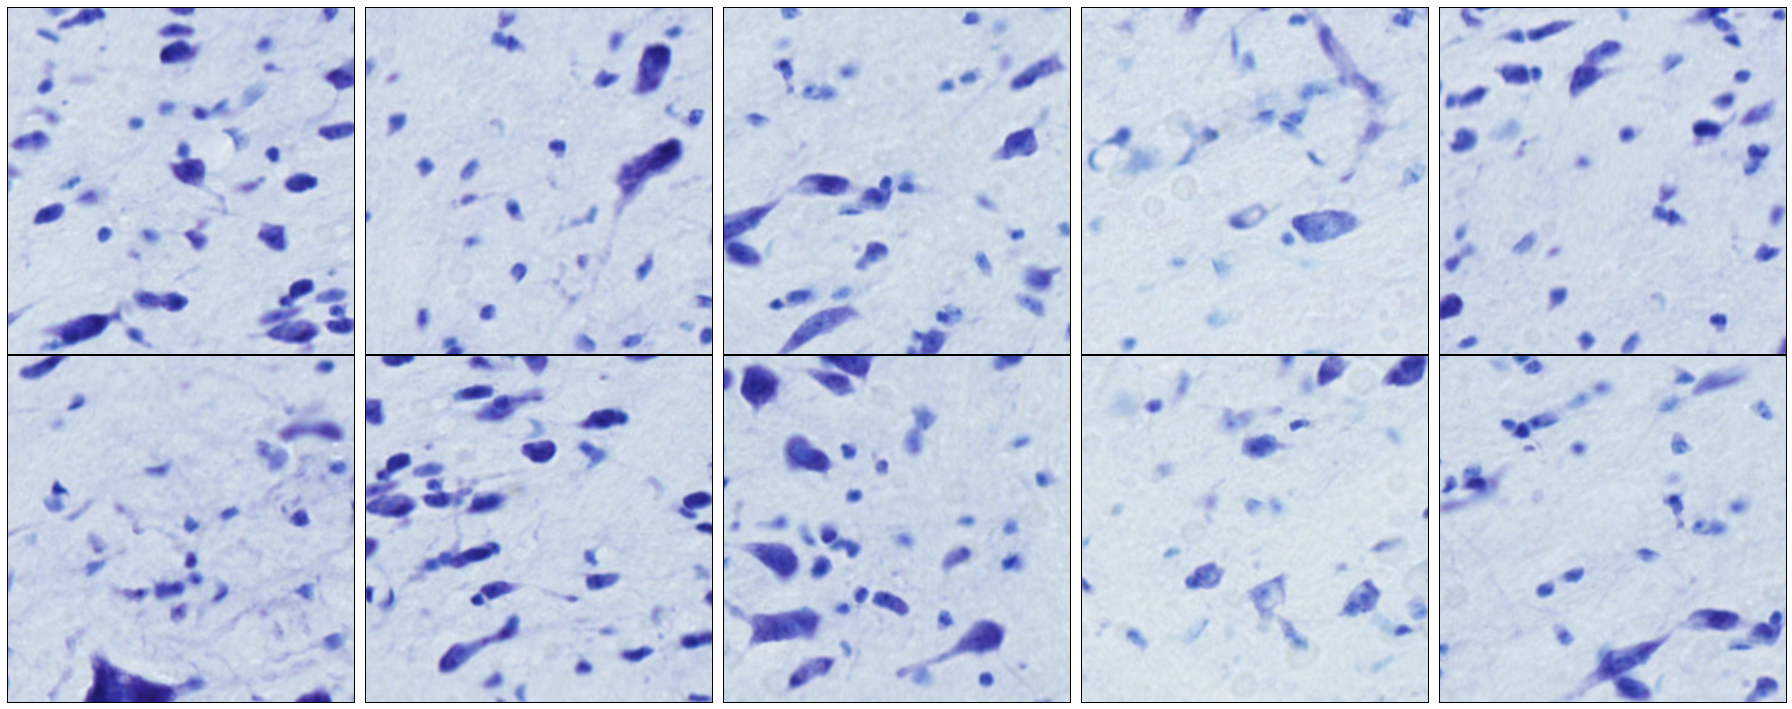

In [9]:
display_images_in_grids(patches['5N_L_surround'][:10], nc=5)

In [116]:
# stack_section_list = set([(stk, sec) for name, loc_list in location_list.iteritems() for stk, sec, ind in loc_list ])

In [117]:
# indices_locations_dict = {(stack, sec): np.loadtxt('/home/yuncong/CSHL_patch_locations/%(stack)s/%(stack)s_%(sec)04d_roi1_indices_locations.txt' % \
#                                                    {'stack':stack, 'sec':sec}, dtype=np.int)
#                           for stk, sec in stack_section_list}

In [130]:
from itertools import groupby

In [131]:
def load_dnn_features(addresses):
    """
    addresses: list of (stack, section, grid_index)
    """
    
    addresses_with_index = [x + (i,) for i, x in enumerate(addresses)]
    
    index_feature_tuple_list = []
    for stack_section, addresses_this_group in groupby(addresses_with_index, lambda x: (x[0], x[1])):
    
        stack, sec = stack_section
    
        gridIndex_location_list = np.loadtxt('/home/yuncong/CSHL_patch_locations/%(stack)s/%(stack)s_%(sec)04d_roi1_indices_locations.txt' % \
                                                       {'stack':stack, 'sec':sec}, dtype=np.int)

        feature_list_curr_section = load_hdf('/home/yuncong/CSHL_patch_features_Sat16ClassFinetuned/%(stack)s/%(stack)s_%(sec)04d_roi1_features.hdf' % \
                                                       {'stack':stack, 'sec':sec})
        
        gridIndex_list = [ind for ind, x, y in gridIndex_location_list]
        index_feature_tuples = [(ind, feature_list_curr_section[gridIndex_list.index(grid_ind)]) for _, _, grid_ind, ind in addresses_this_group]
        index_feature_tuple_list += index_feature_tuples
    
    features_list_originalOrder = [f for i, f in sorted(index_feature_tuple_list)]
    return features_list_originalOrder

In [132]:
features = apply_function_to_dict(load_dnn_features, location_list)

In [ ]:
## load
patches_allClasses = {}

for l in labels_surroundIncluded:
    print l
    vs = load_hdf(training_patches_dir + '/%(stack)s_%(label)s.hdf' % {'stack':stack, 'label':l})
    patches_allClasses[l] = vs

In [22]:
## save
for l, vs in patches_allClasses_sat.iteritems():
    save_hdf(vs, training_patches_dir + '/%(stack)s_%(label)s_sat.hdf' % {'stack':stack, 'label':l})

In [ ]:
## load
patches_allClasses_sat = {}

for l in labels_surroundIncluded:
    print l
    vs = load_hdf(training_patches_dir + '/%(stack)s_%(label)s_sat.hdf' % {'stack':stack, 'label':l})
    patches_allClasses_sat[l] = vs

In [ ]:
# patches_allClasses_reshaped = dict([( l, np.rollaxis(patches, 3, 1) ) 
#                                     for l, patches in patches_allClasses.iteritems()])

In [23]:
patches_allClasses_sat_reshaped = dict([(l, patches[:,None,:,:] ) 
                                        for l, patches in patches_allClasses_sat.iteritems()])

In [38]:
class_len = dict(sorted([(label, len(patches)) for label, patches in patches_allClasses.iteritems()]))
print class_len

{'Tz': 494, 'LRt_surround': 550, '7n': 1150, '5N': 480, 'RtTg': 890, 'Pn': 1030, 'LC': 170, '7N': 860, 'Amb': 120, '12N': 410, '12N_surround': 510, 'R_surround': 560, 'VLL_surround': 570, 'Pn_surround': 1190, 'LC_surround': 370, '7N_surround': 980, 'sp5': 1080, '6N_surround': 190, 'sp5_surround': 1080, 'Tz_surround': 670, 'AP': 174, 'R': 368, 'LRt': 350, 'RtTg_surround': 990, 'VLL': 437, 'AP_surround': 250, '5N_surround': 620, '7n_surround': 1250, '6N': 90, 'Amb_surround': 320}


In [ ]:
model_name='inception-stage1'
model_iteration = 10
init_model = mx.model.FeedForward.load(os.path.join(model_dir, model_name), 
                                     model_iteration, 
                                     ctx=mx.gpu())

arg_params = init_model.arg_params.copy()
arg_params.pop('fullc_bias');
arg_params.pop('fullc_weight');
arg_params['conv_1_weight'] = init_model.arg_params['conv_1_weight'].asnumpy()[:,[0],:,:]

flatten_output = init_model.symbol.get_internals()['flatten_output']

model = mx.model.FeedForward(ctx=mx.gpu(), symbol=flatten_output, num_epoch=model_iteration,
                            arg_params=init_model.arg_params, aux_params=init_model.aux_params,
                            allow_extra_params=True)

In [ ]:
# mean_img = mx.nd.load(os.path.join(model_dir, 'mean_224.nd'))['mean_img'].asnumpy()[0]

In [ ]:
# dm.set_slice(160)

# img_hsv = rgb2hsv(dm.image_rgb_jpg[1500:1600, 1500:1600])

# fig, axes = plt.subplots(3, 2, figsize=(2*3, 3*3))
# axes[0, 0].imshow(img_hsv[..., 0], cmap=plt.cm.gray, vmin=0, vmax=1);
# axes[0, 0].set_title('hue');
# axes[0, 1].imshow(rescale_intensity(img_hsv[..., 0]), cmap=plt.cm.gray, vmin=0, vmax=1);
# axes[0, 1].set_title('rescaled hue');
# axes[1, 0].imshow((1-img_hsv[..., 1]), cmap=plt.cm.gray, vmin=0, vmax=1);
# axes[1, 0].set_title('saturation');
# axes[1, 1].imshow(rescale_intensity(1-img_hsv[..., 1]), cmap=plt.cm.gray, vmin=0, vmax=1);
# axes[1, 1].set_title('rescaled saturation');
# axes[2, 0].imshow(img_hsv[..., 2], cmap=plt.cm.gray, vmin=0, vmax=1);
# axes[2, 0].set_title('value');
# axes[2, 1].imshow(rescale_intensity(img_hsv[..., 2]), cmap=plt.cm.gray, vmin=0, vmax=1);
# axes[2, 1].set_title('rescaled value');

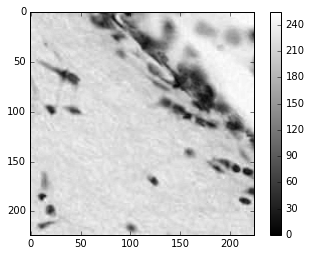

In [25]:
img_sat = patches_allClasses_sat['sp5'][np.random.randint(len(patches_allClasses_sat['sp5']))]
# img_sat = patches_allClasses_sat_concatenated[np.random.randint(patches_allClasses_sat_concatenated.shape[0])]
plt.imshow(img_sat, cmap=plt.cm.gray, vmin=0, vmax=255);
plt.colorbar();

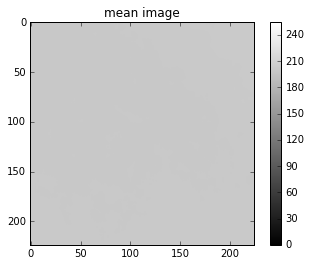

In [26]:
mean_img = np.load(model_dir + '/saturation_mean_224.npy')

plt.imshow(mean_img, cmap=plt.cm.gray, vmin=0, vmax=255);
plt.title('mean image');
plt.colorbar();

In [27]:
patches_allClasses_normalized = dict([(label, patches - mean_img) 
                                      for label, patches in patches_allClasses_sat_reshaped.iteritems()])

In [33]:
model_name = 'Sat16ClassFinetuned'
model_iteration = 10

model = mx.model.FeedForward.load(os.path.join(model_dir, model_name), model_iteration, ctx=mx.gpu())

flatten_output = model.symbol.get_internals()['flatten_output']

model = mx.model.FeedForward(ctx=mx.gpu(), symbol=flatten_output, num_epoch=model_iteration,
                            arg_params=model.arg_params, aux_params=model.aux_params,
                            allow_extra_params=True)

In [29]:
training_features_dir = '/home/yuncong/CSHL_patch_features_%(model_name)s/train_v3' % {'model_name': model_name}
create_if_not_exists(training_features_dir)

'/home/yuncong/CSHL_patch_features_Sat16ClassFinetuned/train_v3'

In [34]:
for label, patches in patches_allClasses_normalized.iteritems():
    
    print label
    
    n = len(patches)
    
#     batch_size = 512 # increasing to 892 does not save any time
    batch_size = min(class_len.values())

    if n < batch_size:
        sys.stderr.write('data size smaller than batch size: %s\n' % label)
        continue
    
    train_iter = mx.io.NDArrayIter(
        patches, 
        np.zeros((n, ), np.int),
        batch_size=batch_size,
        shuffle=False
    )

    t = time.time()

    features = model.predict(train_iter)

    save_hdf(features, training_features_dir + '/%(stack)s_%(label)s_features.hdf' % \
             {'stack': stack, 'label': label})
    
    sys.stderr.write('predict: %.2f seconds\n' % (time.time() - t)) # ~ 3s/class (sample per polygon 10)

Tz
LRt_surround

predict: 2.39 seconds
predict: 1.70 seconds



7n
5N

predict: 3.14 seconds
predict: 1.36 seconds



RtTg
Pn

predict: 2.26 seconds
predict: 2.67 seconds



VLL
7N

predict: 1.16 seconds
predict: 2.23 seconds



Amb
12N

predict: 0.46 seconds
predict: 1.14 seconds



12N_surround
R_surround

predict: 1.32 seconds
predict: 1.58 seconds



VLL_surround
Pn_surround

predict: 1.55 seconds
predict: 3.14 seconds



LC_surround
7N_surround

predict: 1.13 seconds
predict: 2.46 seconds



sp5
6N_surround

predict: 2.69 seconds
predict: 0.70 seconds



sp5_surround
Tz_surround

predict: 2.66 seconds
predict: 1.75 seconds



5N_surround
R

predict: 1.57 seconds
predict: 1.14 seconds



LRt
RtTg_surround

predict: 0.89 seconds
predict: 2.45 seconds



LC
AP_surround

predict: 0.46 seconds
predict: 0.68 seconds



AP
7n_surround

predict: 0.45 seconds
predict: 3.12 seconds



6N
Amb_surround

predict: 0.22 seconds
predict: 0.89 seconds
